# Detecting physical microstate pairs for microscopic pKas

My goal is to indentify physical or unphysical microstate pairs, from a list of enumerated microstates of SAMPL6 molecules.  

A physical microstate pairs is a pair of microstates that can convert to each other by protonation or deprotonation of only one titratable group, while protonation state of the other groups stay constant.  
Total charge difference between physical microstate pairs should be 1.  
Resonance structures or geometric isomers are not considered unique microstates.
A microscopic pKa can be calculated for physical microstate pairs.

If converting a microstate to another requiers protonotation/deprotonation of one titratable group and a shift of  a proton position, then this pair of microstates won't constitute a physical microscopic pKa.

TO-DO:
1. Check if total charge difference is 1 or -1
2. Find maximum common substructure (MCSS)
3. Check that there is only 1 unique MCSS match
4. Check that number of heavy atoms in MCSS match is equal to the number of heavy atoms in target molecule
5. Check that equivalent heavy atoms have equivalent number of bound hydrogens. A physical micorstate pair can have only one heavy atom that has different number of bound hydrogens.

In [1]:
import pandas as pd
import numpy as np
from openeye import oechem, oedepict
import oenotebook as oenb
from IPython.display import HTML, display
from base64 import b64encode

In [2]:
# Example test cases
# a physical microscopic pKa
SM24_micro011 = "COc1ccc(cc1)c2c3c(=[NH+]CCO)[nH]cnc3oc2c4ccc(cc4)OC" # HA+
SM24_micro013 = "COc1ccc(cc1)c2c3c([nH+]cnc3oc2c4ccc(cc4)OC)NCC[O-]" # A 

# not a physical microscopic pKa
SM24_micro010 = "COc1ccc(cc1)c2c3c([nH+]cnc3NCCO)oc2c4ccc(cc4)OC" # HA+
SM24_micro013 = "COc1ccc(cc1)c2c3c([nH+]cnc3oc2c4ccc(cc4)OC)NCC[O-]" # A and a hydrogen shift

In [22]:
def get_labeled_mol(smiles, label='heavy'):
    """
    returns an OEMol with heavy atoms labeled with a specific indice
    """
    mol = oechem.OEMol()
    if not oechem.OESmilesToMol(mol, smiles):
        print("Couldn't parse smiles (%s) returning None" % smiles)
        return None
    
    for idx, a in enumerate(mol.GetAtomIter(oechem.OEIsHeavy())):
        a.SetData('heavy', idx+1)
    
    return mol


class LabelDepictionWithHeavyAtomLabels(oedepict.OEDisplayAtomPropBase):
    def __init__(self):
        oedepict.OEDisplayAtomPropBase.__init__(self)

    def __call__(self, atom):
        if atom.GetData("heavy") > 0 :
            return str(atom.GetData("heavy"))
        return ""

    def CreateCopy(self):
        # __disown__ is required to allow C++ to take
        # ownership of this object and its memory
        copy = LabelDepictionWithHeavyAtomLabels()
        return copy.__disown__()


def display_heavy_atom_labels(mol):
    oedepict.OEPrepareDepiction(mol)
    width, height = 300, 300
    img = oedepict.OEImage(width, height)

    opts = oedepict.OE2DMolDisplayOptions(width, height, oedepict.OEScale_AutoScale)
    atomlabel = LabelDepictionWithHeavyAtomLabels()
    opts.SetAtomPropertyFunctor(atomlabel)
    opts.SetAtomPropLabelFont(oedepict.OEFont(oechem.OEDarkGreen))

    disp = oedepict.OE2DMolDisplay(mol, opts)
    oedepict.OERenderMolecule(img, disp)
    
    return oenb.draw_oeimage_to_img_tag(img)

def display_atom_indices(mol):
    oedepict.OEPrepareDepiction(mol)
    width, height = 300, 300
    img = oedepict.OEImage(width, height)

    opts = oedepict.OE2DMolDisplayOptions(width, height, oedepict.OEScale_AutoScale)
    opts.SetAtomPropertyFunctor(oedepict.OEDisplayAtomIdx())
    opts.SetAtomPropLabelFont(oedepict.OEFont(oechem.OEDarkBlue))

    disp = oedepict.OE2DMolDisplay(mol, opts)
    oedepict.OERenderMolecule(img, disp)
    
    return oenb.draw_oeimage_to_img_tag(img)

def get_total_charge(smiles):
    mol = oechem.OEMol()
    oechem.OESmilesToMol(mol,smiles)

    total_charge = 0
    for a in mol.GetAtomIter():
        total_charge += a.GetFormalCharge()
    return total_charge

def compare_total_charge(smiles1, smiles2):
    total_charge1 = get_total_charge(smiles1)
    total_charge2 = get_total_charge(smiles2)
    if total_charge1 == total_charge2:
        return True
    else:
        return False
    
def calculate_total_charge_difference(smiles1, smiles2):
    charge_difference = get_total_charge(smiles1) - get_total_charge(smiles2)
    return charge_difference
    
def draw_subsearch_highlights(mol, subsearch, width=300., height=300.):
    opts = oedepict.OE2DMolDisplayOptions(width, height, oedepict.OEScale_AutoScale)

    mol = oechem.OEGraphMol(mol)
    oedepict.OEPrepareDepiction(mol)
    img = oedepict.OEImage(width, height)
    hstyle = oedepict.OEHighlightByBallAndStick(oechem.OEBlueTint)

    disp = oedepict.OE2DMolDisplay(mol, opts)
    unique = True
    for match in subsearch.Match(mol, unique):
        oedepict.OEAddHighlighting(disp, hstyle, match)
    
    oedepict.OERenderMolecule(img, disp)
    return oenb.draw_oeimage_to_img_tag(img)

def count_heavy_atoms(mol):
    heavy_atom_count = 0
    for idx, atom in enumerate(m.GetAtomIter()):
        heavy_atom_count = idx + 1
        #print(atom, atom.GetData()) # Target mol has labelled heavy atoms
    return heavy_atom_count

def get_total_hydrogen_count(mol):
    hydrogen_count = 0
    
    for idx, atom in enumerate(mol.GetAtomIter()):
        hydrogen_count += atom.GetTotalHCount()
    
    return hydrogen_count

def get_mcss(mol1, mol2):
    """
    Finds maximum common substructure based on atomic number criteria 
    and returns the match as a mol object.
    
    MCSS should result in only 1 match.
    """
    #atomexpr = oechem.OEExprOpts_AtomicNumber
    #bondexpr = oechem.OEExprOpts_EqSingleDouble # single or double bonds are considered identical

    bondexpr = oechem.OEExprOpts_DefaultBonds
    atomexpr = oechem.OEExprOpts_DefaultAtoms 
    
    # create maximum common substructure object
    mcss = oechem.OEMCSSearch(mol1, atomexpr, bondexpr, oechem.OEMCSType_Exhaustive)
    
    # set scoring function
    mcss.SetMCSFunc(oechem.OEMCSMaxAtoms())

    # ignore matches smaller than 6 atoms
    mcss.SetMinAtoms(6)
    unique = True

    # loop over matches
    for i, match in enumerate(mcss.Match(mol2, unique)):
        count = i + 1
        print ("Match %d:" % (count))
        print ("pattern atoms:", end=" ")
        for ma in match.GetAtoms():
            print (ma.pattern.GetIdx(), end=" ")
        print ("\ntarget atoms: ", end=" ")
        for ma in match.GetAtoms():
            print (ma.target.GetIdx(), end=" ")

        # create match subgraph
        m = oechem.OEGraphMol()
        oechem.OESubsetMol(m, match, True)

        print ("\nmatch smiles =", oechem.OEMolToSmiles(m))

    # check if there is only single match
    if (count != 1):
        print("Warning! There is multiple matches.")
    else:
        print("Exactly one match.")
        
    return m

In [4]:
print("Total charge of micro010:", get_total_charge(SM24_micro010))
print("Total charge of micro011:", get_total_charge(SM24_micro011))
print("Total charge of micro013:", get_total_charge(SM24_micro013))

Total charge of micro010: 1
Total charge of micro011: 1
Total charge of micro013: 0


## Example of physical pKa microstate pairs
SM24_micro011 and SM24_micro13

In [5]:
pattern = get_labeled_mol(SM24_micro011) # HA+
target = get_labeled_mol(SM24_micro013) # A

# check if total charge difference is 1.
charge_difference = int(calculate_total_charge_difference(SM24_micro011, SM24_micro013))
print("Total charge difference is: ", charge_difference)
print()

# check the difference of hydrogen counts
print("Total hydrogen count of pattern: ", get_total_hydrogen_count(pattern))
print("Total hydrogen count of target: ", get_total_hydrogen_count(target))

Total charge difference is:  1

Total hydrogen count of pattern:  22
Total hydrogen count of target:  21


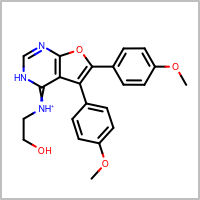

In [6]:
oenb.draw_mol(pattern)

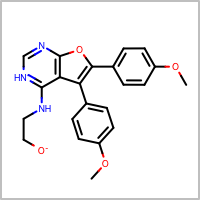

In [7]:
oenb.draw_mol(target)

### Deciding on correct MCSS settings

In [8]:
# Find MCSS
#atomexpr = oechem.OEExprOpts_DefaultAtoms 
atomexpr = oechem.OEExprOpts_AtomicNumber 
bondexpr = oechem.OEExprOpts_EqSingleDouble # single or double bonds are considered identical

# create maximum common substructure object
mcss = oechem.OEMCSSearch(pattern, atomexpr, bondexpr, oechem.OEMCSType_Exhaustive)
mcss

<oechem.OEMCSSearch; proxy of <Swig Object of type 'OEChem::OEMCSSearch *' at 0x1183d9390> >

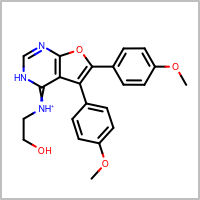

In [9]:
oenb.draw_mol(pattern)


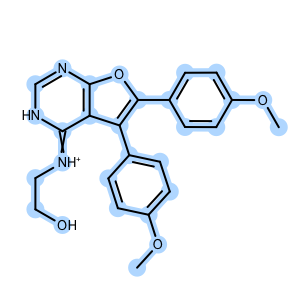

In [10]:
HTML(draw_subsearch_highlights(pattern,mcss))


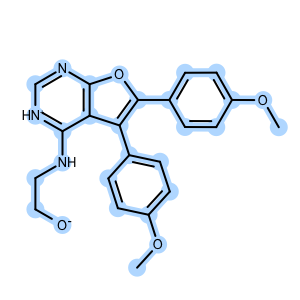

In [11]:
HTML(draw_subsearch_highlights(target,mcss)) # Highlighted regions of target shows the MCSS match


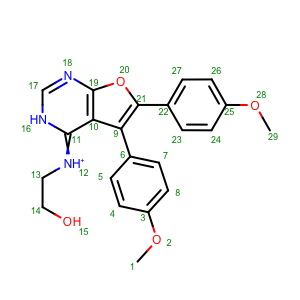

In [12]:
# Display heavy atom labels
HTML(display_heavy_atom_labels(pattern))


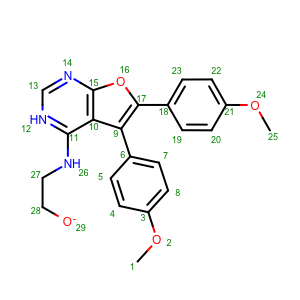

In [13]:
HTML(display_heavy_atom_labels(target))

Match substructures heavy atom labels are inherited from target molecule, not the pattern molecule.  
I need to switch the order of pattern and target molecules to get the other pair match.

### MCSS Matching of Two Structures in Both Directions

Match 1:
pattern atoms: 0 1 2 3 4 5 6 7 8 9 10 15 16 17 18 19 20 21 22 23 24 25 26 27 28 
target atoms:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 
match smiles = COc1ccc(cc1)c2c3c[nH+]cnc3oc2c4ccc(cc4)OC
Match 2:
pattern atoms: 0 1 2 3 4 5 6 7 8 9 10 15 16 17 18 19 20 21 22 23 24 25 26 27 28 
target atoms:  0 1 2 3 4 5 6 7 8 9 14 13 12 11 10 15 16 17 18 19 20 21 22 23 24 
match smiles = COc1ccc(cc1)C(=C(c2ccc(cc2)OC)O)c3c[nH+]cnc3
Warning! There is multiple matches.



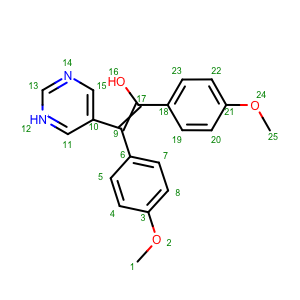

In [23]:
m1 = get_mcss(pattern, target)
HTML(display_heavy_atom_labels(m1)) # displays custom heavy atom labels inherited from target

Match 1:
pattern atoms: 0 1 2 3 4 5 6 7 8 9 10 12 13 14 15 16 17 18 19 20 21 22 23 24 
target atoms:  0 1 2 3 4 5 6 7 8 9 10 16 17 18 19 20 21 22 23 24 25 26 27 28 
match smiles = Cc1c(c(oc1N=C)c2ccc(cc2)OC)c3ccc(cc3)OC
Match 2:
pattern atoms: 0 1 2 3 4 5 6 7 8 9 10 12 13 14 15 16 17 18 19 20 21 22 23 24 
target atoms:  0 1 2 3 4 5 6 7 8 9 18 16 15 10 19 20 21 22 23 24 25 26 27 28 
match smiles = CNCC(=C)C(=C(c1ccc(cc1)OC)O)c2ccc(cc2)OC
Warning! There is multiple matches.



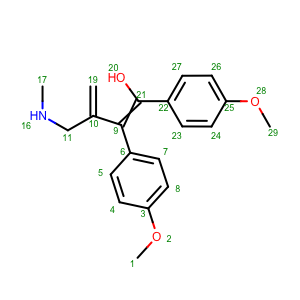

In [24]:
m2 = get_mcss(target, pattern)
HTML(display_heavy_atom_labels(m2)) # displays custom heavy atom labels inherited from pattern


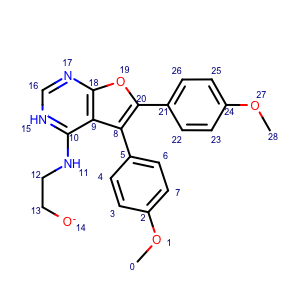

In [17]:
# Let's check if automatic atom indices are the same in m1 and m2 
HTML(display_atom_indices(m1))


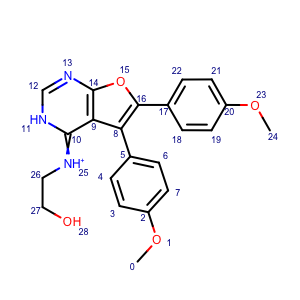

In [18]:
HTML(display_atom_indices(m2))

### How to get bound hydrogen counts of pattern and target molecules using MCSS heavy atoms labels?

In [31]:
# create numpy arrays to store heavy atom hydrogen counts
pattern_HCount_array = np.zeros(count_heavy_atoms(pattern))
target_HCount_array = np.zeros(count_heavy_atoms(target))

# iterate over heavy atom labels of match substructure m1
for i, atom in enumerate(m1.GetAtomIter()):
    label = atom.GetData("heavy")
    print("Heavy atom label: ", label)
      
    # find the heavy atom with the same label in pattern molecule and get H-count
    for j, p_atom in enumerate(pattern.GetAtomIter()):
        pattern_label = p_atom.GetData("heavy")
        
        if pattern_label == label:
            p_atom_Hcount = p_atom.GetTotalHCount()
            print("Pattern H count: ", p_atom_Hcount)
            pattern_HCount_array[i] =  p_atom_Hcount

    # find the heavy atom with the same label in target molecule and get H-count
    for h, t_atom in enumerate(target.GetAtomIter()):
        target_label = t_atom.GetData("heavy")
        
        if target_label == label:
            t_atom_Hcount = t_atom.GetTotalHCount()
            print("Target H count:  ", t_atom_Hcount)
            target_HCount_array[i] =  t_atom_Hcount
        
    print()

print()
print("Pattern H count array:")
print(pattern_HCount_array)

print("Target H count array:")
print(target_HCount_array)

Heavy atom label:  1
Pattern H count:  3
Target H count:   3

Heavy atom label:  2
Pattern H count:  0
Target H count:   0

Heavy atom label:  3
Pattern H count:  0
Target H count:   0

Heavy atom label:  4
Pattern H count:  1
Target H count:   1

Heavy atom label:  5
Pattern H count:  1
Target H count:   1

Heavy atom label:  6
Pattern H count:  0
Target H count:   0

Heavy atom label:  7
Pattern H count:  1
Target H count:   1

Heavy atom label:  8
Pattern H count:  1
Target H count:   1

Heavy atom label:  9
Pattern H count:  0
Target H count:   0

Heavy atom label:  10
Pattern H count:  0
Target H count:   0

Heavy atom label:  15
Pattern H count:  1
Target H count:   0

Heavy atom label:  14
Pattern H count:  2
Target H count:   0

Heavy atom label:  13
Pattern H count:  2
Target H count:   1

Heavy atom label:  12
Pattern H count:  1
Target H count:   1

Heavy atom label:  11
Pattern H count:  0
Target H count:   0

Heavy atom label:  16
Pattern H count:  1
Target H count:   0

H

AttributeError: type object 'object' has no attribute '__getattr__'

In [ ]:
for idx, atom in enumerate(target.GetAtomIter()):
    print(idx, atom.GetAtomicNum(), atom.GetTotalHCount(), atom.GetData("heavy"))

In [15]:
for idx, atom in enumerate(m.GetAtomIter()):
    print(idx, atom.GetAtomicNum(), atom.GetTotalHCount(), atom.GetData("heavy"))

0 6 3 0
1 8 0 1
2 6 0 2
3 6 1 3
4 6 1 4
5 6 0 5
6 6 1 6
7 6 1 7
8 6 0 8
9 6 0 9
10 6 0 10
11 7 1 25
12 6 2 26
13 6 2 27
14 8 0 28
15 7 1 11
16 6 1 12
17 7 0 13
18 6 0 14
19 8 0 15
20 6 0 16
21 6 0 17
22 6 1 18
23 6 1 19
24 6 0 20
25 6 1 21
26 6 1 22
27 8 0 23
28 6 3 24


In [16]:
def count_heavy_atoms_with_different_number_of_hydrogens(target, match):
    target_HCount_array = np.zeros(count_heavy_atoms(target))
    print(target_HCount_array)
    
    match_HCount_array = np.zeros(count_heavy_atoms(target))
    print(target_HCount_array)
    

count_heavy_atoms_with_different_number_of_hydrogens(target, m)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
